In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm

In [20]:
monthly_temp = pd.read_csv(r'C:\Users\augus\Documents\Python Scripts\coursera_tsa\week3\mean-monthly-temperature-1907-19.csv',
                           skipfooter=2, infer_datetime_format=True, header=0, index_col=0, engine='python', names=['month', 'temp'])
monthly_temp

,temp
month,
1907-01,33.3
1907-02,46.0
1907-03,43.0
1907-04,55.0
1907-05,51.8
...,...
1972-08,75.6
1972-09,64.1
1972-10,51.7


In [21]:
monthly_temp.index = pd.to_datetime(monthly_temp.index)
monthly_temp

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8
...,...
1972-08-01,75.6
1972-09-01,64.1
1972-10-01,51.7


In [22]:
monthly_temp.describe()

,temp
count,792.000000
mean,53.553662
std,15.815452
min,11.200000
25%,39.675000
50%,52.150000
75%,67.200000
max,82.400000


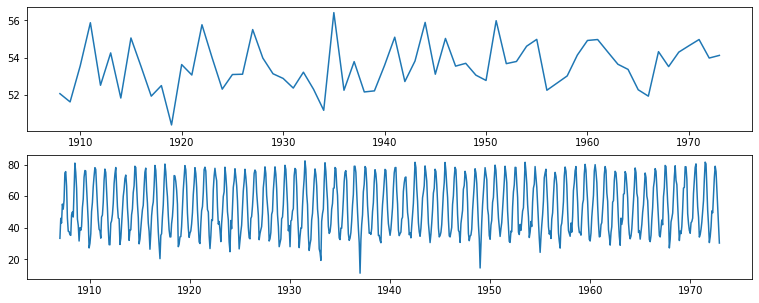

In [30]:
# resample to annual data and plot 
annual_temp = monthly_temp.resample('A').mean()
annual_temp.head()
fig, axes = plt.subplots(2, 1, figsize=[13,5])
axes[0].plot(annual_temp)
axes[1].plot(monthly_temp)

<AxesSubplot:xlabel='month', ylabel='temp'>

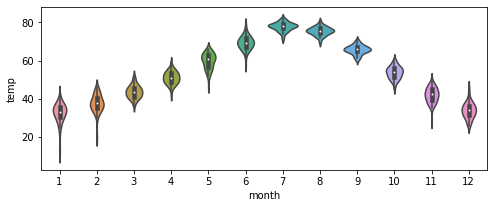

In [52]:
# check seasonality with violinplot
plt.rcParams['figure.figsize'] = [8, 3]
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp)

In [40]:
dftest = ts.adfuller(monthly_temp)
dftest

(-6.481466436831952,
 1.2918674573935615e-08,
 21,
 770,
 {'1%': -3.4388710830827125,
  '5%': -2.8653008652386576,
  '10%': -2.568772659807725},
 4336.4223317525975)

In [44]:
# define a function for adftest 
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', 'lags used', 'observations used'])
    
    for key,value in dftest[4].items():
        dfoutput[f'critical value {key}'] = value
    print(dfoutput)

dftest(monthly_temp)
# p-value suggests we can reject unit root, therefore data is stationary 

test statistic       -6.481466e+00
p-value               1.291867e-08
lags used             2.100000e+01
observations used     7.700000e+02
critical value 1%    -3.438871e+00
critical value 5%    -2.865301e+00
critical value 10%   -2.568773e+00
dtype: float64


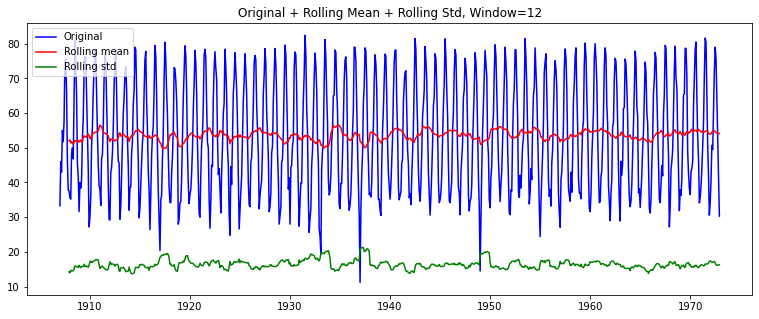

In [50]:
# define function to plot rolling statistic 
def rolling_plot(timeseries, window):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    std = plt.plot(rolstd, color='green', label='Rolling std')
    plt.legend(loc='best')
    plt.title(f'Original + Rolling Mean + Rolling Std, Window={window}')

rolling_plot(monthly_temp, window=12)
# rolling plot shows constant mean and variance(std) at window=12

test statistic       -7.878242e+00
p-value               4.779473e-12
lags used             0.000000e+00
observations used     6.500000e+01
critical value 1%    -3.535217e+00
critical value 5%    -2.907154e+00
critical value 10%   -2.591103e+00
dtype: float64


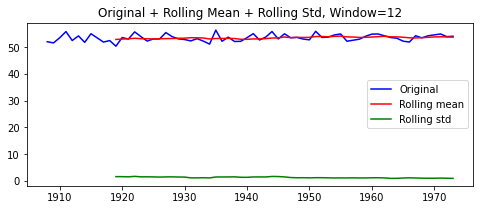

In [54]:
# check annual temp 
dftest(annual_temp)
rolling_plot(annual_temp, window=12)

In [56]:
# perform differencing to remove seasonality 

monthly_temp['lag12'] = monthly_temp.shift(12)
monthly_temp['seasonal_diff'] = monthly_temp.temp - monthly_temp['lag12']
monthly_temp

,temp,lag12,seasonal_diff
month,,,
1907-01-01,33.3,NaN,NaN
1907-02-01,46.0,NaN,NaN
1907-03-01,43.0,NaN,NaN
1907-04-01,55.0,NaN,NaN
1907-05-01,51.8,NaN,NaN
...,...,...,...
1972-08-01,75.6,80.5,-4.9
1972-09-01,64.1,65.8,-1.7
1972-10-01,51.7,51.1,0.6


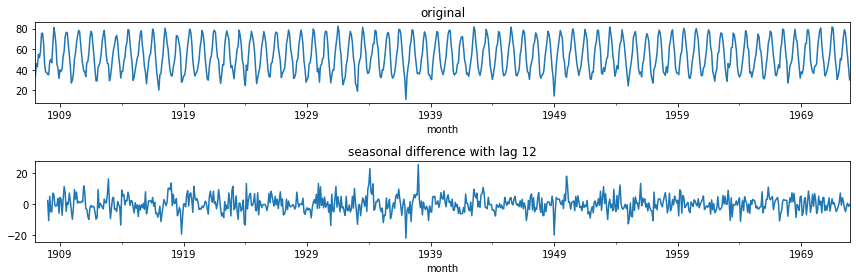

In [61]:
fig, axes = plt.subplots(2,1, figsize=[12, 4])
monthly_temp['temp'].plot(title='original', ax=axes[0])
monthly_temp['seasonal_diff'].plot(title='seasonal difference with lag 12', ax=axes[1])
plt.tight_layout()

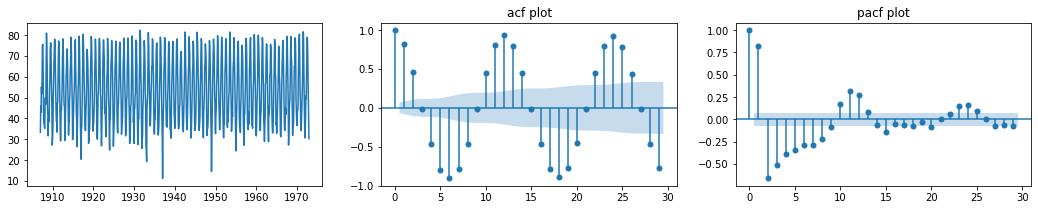

In [69]:
def helper_plots(data, lags=None):
    fig, axes = plt.subplots(1,3, figsize=[18,3])

    original = axes[0].plot(data)
    acf = sm.tsa.graphics.plot_acf(data, lags=lags, title='acf plot', ax=axes[1])
    pacf = sm.tsa.graphics.plot_pacf(data, lags=lags, title='pacf plot', ax=axes[2])
    plt.tight_layout

helper_plots(monthly_temp.temp)


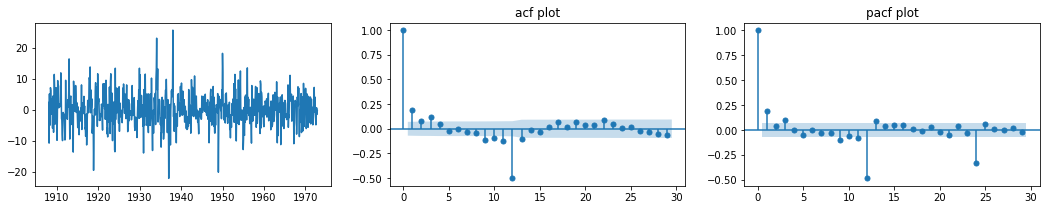

In [74]:
helper_plots(monthly_temp.seasonal_diff.dropna())

In [85]:
# only seasonal diff
sar1 = sm.tsa.statespace.SARIMAX(monthly_temp.temp, order=(0,0,0), seasonal_order=(0,1,0,12), trend='c').fit()
sar1.summary()

C:\Users\augus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\augus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                     temp   No. Observations:                  792
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood               -2396.419
Date:                  Mon, 04 Jan 2021   AIC                           4796.839
Time:                          14:27:59   BIC                           4806.158
Sample:                      01-01-1907   HQIC                          4800.423
                           - 12-01-1972                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0315      0.188      0.168      0.867      -0.337       0.400
sigma2        27.2973      1.000     27.300      0.000      25.338      29.257
===================================================================================
Ljung-Box (L1) (Q):                  28.70   Jarque-Bera (JB):               115.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

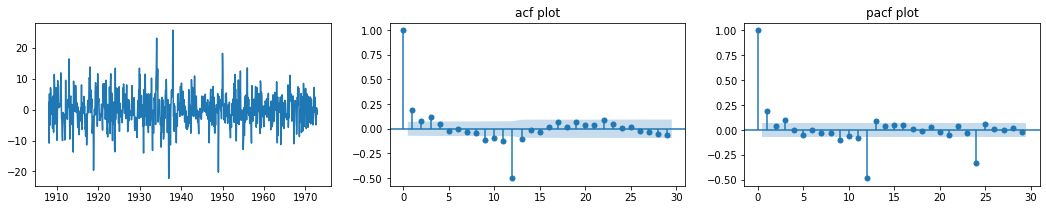

In [86]:
# plot residual 
helper_plots(sar1.resid[sar1.loglikelihood_burn:])
# seasonal diff is enough


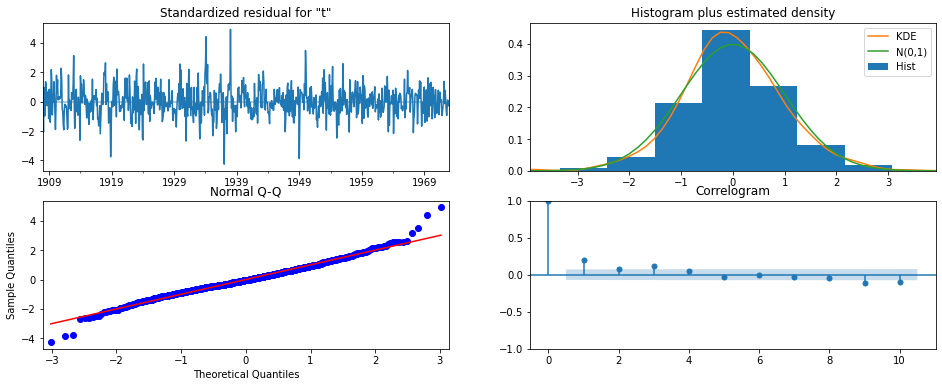

In [131]:
sar1.plot_diagnostics(figsize=(16, 6));

In [90]:
# first diff + seasonal diff
sar2 = sm.tsa.statespace.SARIMAX(monthly_temp.temp, order=(0,1,0), sesaonal_order=(0,1,0,12), trend='c').fit()
sar2.summary()

C:\Users\augus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\augus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   temp   No. Observations:                  792
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2898.932
Date:                Mon, 04 Jan 2021   AIC                           5801.864
Time:                        14:29:18   BIC                           5811.210
Sample:                    01-01-1907   HQIC                          5805.456
                         - 12-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0038      0.339     -0.011      0.991      -0.668       0.660
sigma2        89.2921      6.065     14.722      0.000      77.404     101.180
===================================================================================
Ljung-Box (L1) (Q):                 214.71   Jarque-Bera (JB):                28.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.14
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

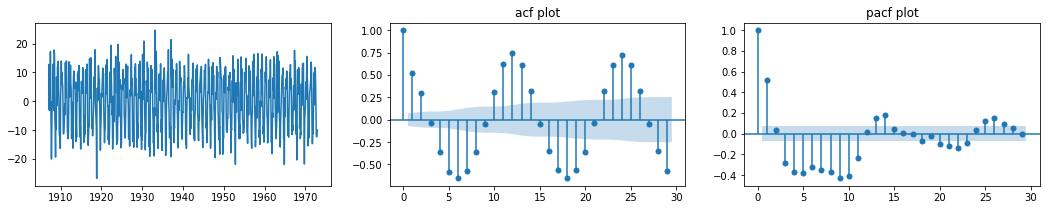

In [91]:
helper_plots(sar2.resid[sar2.loglikelihood_burn:])
# adding first diff increase autocorrelation 

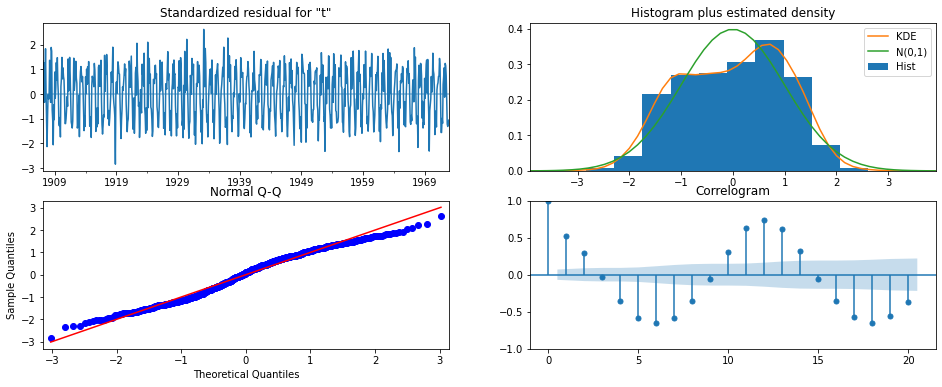

In [134]:
sar2.plot_diagnostics(figsize=(16,6), lags=20);

In [122]:
# p=1, d=0, P=0, D=1, Q=1
sar3 = sm.tsa.statespace.SARIMAX(monthly_temp.temp, order=(1,0,0), seasonal_order=(0,1,1,12), trend='c').fit()
sar3.summary()

C:\Users\augus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\augus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  792
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -2128.873
Date:                              Mon, 04 Jan 2021   AIC                           4265.746
Time:                                      15:11:53   BIC                           4284.383
Sample:                                  01-01-1907   HQIC                          4272.914
                                       - 12-01-1972                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0127      0.007      1.698      0.090      -0.002       0.027
ar.L1          0.1791      0.035      5.105      0.000       0.110       0.248
ma.S.L12      -0.9995      1.127     -0.887      0.375      -3.209       1.210
sigma2        12.8930     14.415      0.894      0.371     -15.359      41.145
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               252.77
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.56
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

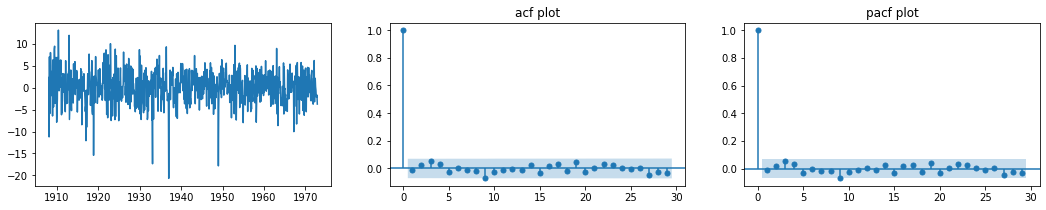

In [123]:
helper_plots(sar3.resid[sar3.loglikelihood_burn:])

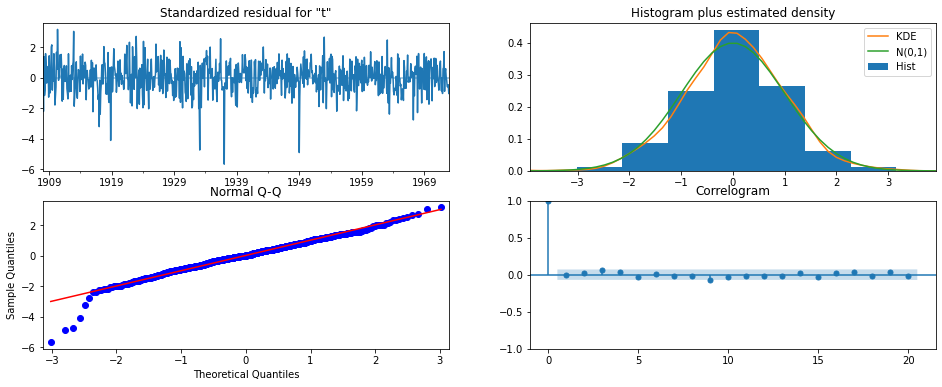

In [136]:
sar3.plot_diagnostics(figsize=(16,6), lags=20);

In [173]:
sar4 = sm.tsa.statespace.SARIMAX(monthly_temp.seasonal_diff, order=(1,0,0), seasonal_order=(0,0,1,12)).fit()
sar4.summary()
# sar3 is the same model as sar4

C:\Users\augus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\augus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        seasonal_diff   No. Observations:                  792
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood               -2130.659
Date:                              Tue, 05 Jan 2021   AIC                           4267.317
Time:                                      14:57:26   BIC                           4281.341
Sample:                                  01-01-1907   HQIC                          4272.707
                                       - 12-01-1972                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1846      0.035      5.235      0.000       0.115       0.254
ma.S.L12      -0.9896      0.049    -20.150      0.000      -1.086      -0.893
sigma2        13.0665      0.704     18.550      0.000      11.686      14.447
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               270.92
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.58
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

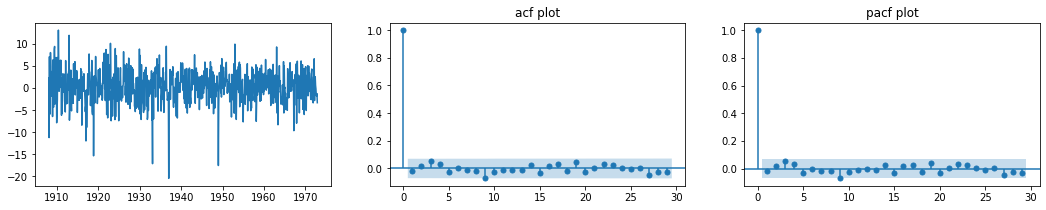

In [125]:
helper_plots(sar4.resid[sar4.loglikelihood_burn:].dropna())

<AxesSubplot:xlabel='month'>

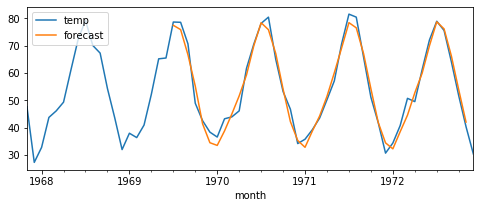

In [146]:
# plot prediction 

#pd.plotting.register_matplotlib_converters()

monthly_temp['forecast'] = sar3.predict(start=750, end=790)
monthly_temp[730:][['temp','forecast']].plot()

In [149]:
# forecast the future 
future_fcst = sar3.get_forecast(50)

# get confidence interval at 5%
confidence_int = future_fcst.conf_int(alpha=0.05)

# get mean of forecast 
fcst = future_fcst.predicted_mean

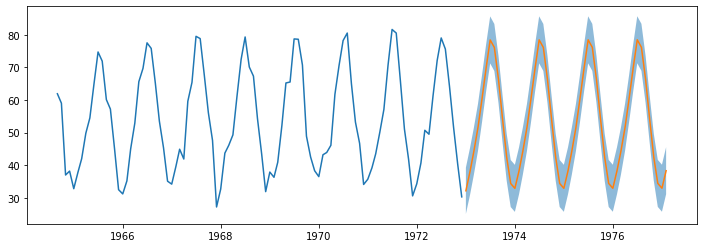

In [164]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(monthly_temp.temp[-100:])
plt.plot(fcst)
plt.fill_between(confidence_int.index, confidence_int['lower temp'], confidence_int['upper temp'], alpha=0.5)